<h3>Load helper functions</h3>

In [1]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [2]:
gk_issues = load_gk_issues_for_analysis()
non_gk_issues = load_non_gk_issues_for_analysis()

<h2><b>Code Changes</b></h2>

In [5]:
# commits = load_commits()
commits = load_bens_collected_commits()

# Create Commit to GKIR Relationship DF
commit_to_gkir_rel = commits[['commit_sha', 'issue_id', 'repo_name']].copy()
commit_to_gkir_rel = commit_to_gkir_rel.drop_duplicates()

# Drop any duplicates (i.e., if the same commit was reference from 2 different issue reports)
commits = commits.drop(columns=['issue_id', 'repo_name'])
commits = commits.drop_duplicates()

In [10]:
# Load Non-GKIR commits
ngkir_commits = load_ngkir_commits()
# Load commit to non-gkir relationship events
commit_to_ngkir_rel = load_commit_event_relationships()
# Only keep events that we have a commit for
commit_to_ngkir_rel = commit_to_ngkir_rel[commit_to_ngkir_rel['commit_sha'].isin(ngkir_commits['commit_sha'])]

commit_to_ngkir_rel = commit_to_ngkir_rel.drop(columns=['commit_url'])
ngkir_commits = ngkir_commits.merge(
    commit_to_ngkir_rel[['commit_sha', 'event_type']],
    on='commit_sha'
)
ngkir_commits = ngkir_commits[ngkir_commits['event_type'] == 'referenced']
ngkir_commits = ngkir_commits.drop(columns=['event_type'])

In [11]:
print(f"{commits['commit_sha'].nunique()} GKIR commits")
print(f"{ngkir_commits['commit_sha'].nunique()} non-GKIR commits")

2044 GKIR commits
88386 non-GKIR commits


In [12]:
# Add Short file name and only file name
def extract_short_file_name(row):
    if row['file_name'].rfind('/') < 0:
        return row['file_name']
    return f".../{row['file_name'][row['file_name'].rfind('/')+1:]}"

def extract_only_file_name(row):
    if row['file_name'].rfind('/') < 0:
        return row['file_name']
    return f"{row['file_name'][row['file_name'].rfind('/')+1:]}"

commits['short_file_name'] = commits.apply(extract_short_file_name, axis=1).astype('category')
commits['only_file_name'] = commits.apply(extract_only_file_name, axis=1).astype('category')

ngkir_commits['short_file_name'] = ngkir_commits.apply(extract_short_file_name, axis=1).astype('category')
ngkir_commits['only_file_name'] = ngkir_commits.apply(extract_only_file_name, axis=1).astype('category')

In [13]:
count = commit_to_gkir_rel[commit_to_gkir_rel['repo_name'].isin(commit_to_ngkir_rel['repo_name'])]['repo_name'].nunique()
print(f"Out of {commit_to_gkir_rel['repo_name'].nunique()} repos with GKIR commits, we have collected commits on non-GKIR issues from {count} of those repos")

Out of 779 repos with GKIR commits, we have collected commits on non-GKIR issues from 617 of those repos


## Helpfer functions for filtering commits

In [17]:
DEPS_SPEC_FILES = ['package.json', 'package-lock.json', 'yarn.lock', '.../package.json', '.../package-lock.json']
PACKAGE_JSON = ['package.json']

def commit_changes_file(commit_changes, list_of_files):    
    commit_changes_for_list_of_files = commit_changes[commit_changes['only_file_name'].isin(list_of_files)]
    return len(commit_changes_for_list_of_files) > 0

def commit_only_changes_files(commit_changes, list_of_files):
    count_of_file_changes = len(commit_changes)
    count_of_changes_that_change_list_of_files = len(commit_changes[commit_changes['only_file_name'].isin(list_of_files)])
    return count_of_file_changes == count_of_changes_that_change_list_of_files


<h3>How often do GKIR commits change dependency files?</h3>

In [15]:
commit_count = commits['commit_sha'].nunique()

In [18]:
changes_package_json = commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, list_of_files=PACKAGE_JSON))
changes_package_json_count = changes_package_json['commit_sha'].nunique()
print(f'{calculate_percent(changes_package_json_count, commit_count)}% of commits change the package.json file')

77.74% of commits change the package.json file


In [20]:
changes_dep_files = commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, DEPS_SPEC_FILES))
changes_dep_file_count = changes_dep_files['commit_sha'].nunique()
print(f'{calculate_percent(changes_dep_file_count, commit_count)}% of commits change at least 1 dependency specification file')

82.49% of commits change at least 1 dependency specification file


In [22]:
changes_dep_files_only = commits.groupby('commit_sha').filter(lambda group: commit_only_changes_files(group, DEPS_SPEC_FILES))
changes_dep_file_only_count = changes_dep_files_only['commit_sha'].nunique()
print(f'{calculate_percent(changes_dep_file_only_count, commit_count)}% of commits change only dependency specification files')

55.87% of commits change only dependency specification files


<h2>Comparison with non-GKIR</h2>

<h3>Intra-project</h3>

In [29]:
# Get commit_to_gkir_rel rows for commits that don't only change dependency files
# NOTE - This might be why R1.6 exists - you are only looking at commits that do NOT only change dependency spec files, 
# which excludes all those only package.json changes
changes_dep_files_only = commits.groupby('commit_sha').filter(lambda group: commit_only_changes_files(group, deps_spec_files))
gkir_changes_other_files = commits[~commits['commit_sha'].isin(changes_dep_files_only['commit_sha'].unique())]
shas =  gkir_changes_other_files['commit_sha'].unique()
commit_to_gkir_rel__commit_changes_other_files = commit_to_gkir_rel[commit_to_gkir_rel['commit_sha'].isin(shas)]

# changes_dep_files_only = commits.groupby('commit_sha').filter(lambda group: commit_only_changes_files(group, deps_spec_files))
# gkir_changes_other_files = commits[~commits['commit_sha'].isin(changes_dep_files_only['commit_sha'].unique())]
shas =  commits['commit_sha'].unique()
commit_to_gkir_rel__commit_changes_other_files = commit_to_gkir_rel[commit_to_gkir_rel['commit_sha'].isin(shas)]

# Only GKIRs with a referenced commit
gkirs_w_referenced_commit = gk_issues[gk_issues['id'].isin(commit_to_gkir_rel__commit_changes_other_files['issue_id'])].copy()
# Only non-GKIRs from the same project
ngkirs_for_matching_projects = non_gk_issues[non_gk_issues['repo_name'].isin(gkirs_w_referenced_commit['repo_name'])]
# Only Non-gkirs with a referenced commit
ngkirs_for_matching_projects_w_referenced_commit = ngkirs_for_matching_projects[ngkirs_for_matching_projects['id'].isin(commit_to_ngkir_rel['issue_id'])]


# For every gkir with a referenced commit
# Get the closest non-gkir in the same project with a referenced commit
def get_previous_ngkir_id_w_referenced_commit(gkir):
    repo_ngkirs = (
        ngkirs_for_matching_projects_w_referenced_commit[
            ngkirs_for_matching_projects_w_referenced_commit['repo_name'] == gkir['repo_name']
        ]
    )
    if len(repo_ngkirs) == 0:
        return pd.NA
    col = 'created_at'
    ngkirs_closed_before_gkir = (
        repo_ngkirs[
            repo_ngkirs[col] < gkir[col]
        ]
    )
    closest_at_top = (
        ngkirs_closed_before_gkir
            .sort_values(by=col, ascending=False)
    )
    if len(closest_at_top) == 0:
        ngkirs_closed_after_gkir = (
            repo_ngkirs[
                repo_ngkirs[col] > gkir[col]
            ]
        )
        closest_at_top = (
            ngkirs_closed_before_gkir
                .sort_values(by=col, ascending=True)
        )
    if len(closest_at_top) == 0:
        return pd.NA
    ngkir_closest_to_gkir = closest_at_top.iloc[0]
    return ngkir_closest_to_gkir['id']
        
gkirs_w_referenced_commit['closest_ngkir_id'] = (
    gkirs_w_referenced_commit.apply(
        get_previous_ngkir_id_w_referenced_commit,
        axis=1
    )
)

In [75]:
# Get commits referenced from gkirs
# NOTE - gkirs_w_referenced_commit is only commits that dont only change dep spec files
gkir_referenced_commit_rels = commit_to_gkir_rel[commit_to_gkir_rel['issue_id'].isin(gkirs_w_referenced_commit['id'])]

gkir_referenced_commits = commits[commits['commit_sha'].isin(gkir_referenced_commit_rels['commit_sha'].unique())]
gkir_referenced_commits['commit_sha'].nunique()

# Get commits referenced from non-gkirs
ngkir_referenced_commit_rels = commit_to_ngkir_rel[commit_to_ngkir_rel['issue_id'].isin(gkirs_w_referenced_commit['closest_ngkir_id'])]
ngkir_referenced_commits = ngkir_commits[ngkir_commits['commit_sha'].isin(ngkir_referenced_commit_rels['commit_sha'].unique())]

print(f"For matching GKIR commits and their closest non-GKIR commit...")
print(f"{gkir_referenced_commits['commit_sha'].nunique()} GKIR commits...")
print(f"{ngkir_referenced_commits['commit_sha'].nunique()} non-GKIR commits...")

For matching GKIR commits and their closest non-GKIR commit...
2044 GKIR commits...
698 non-GKIR commits...


<h3>How many files do these commits change?</h3>

In [ ]:
gkir_number_of_file_changes = (
    gkir_referenced_commits
        .groupby('commit_sha')['file_name']
        .count()
        .to_frame(name='files_changed')
        .reset_index()
)
gkir_number_of_file_changes['type'] = 'gkir'
ngkir_number_of_file_changes = (
    ngkir_referenced_commits
        .groupby('commit_sha')['file_name']
        .count()
        .to_frame(name='files_changed')
        .reset_index()
)
ngkir_number_of_file_changes['type'] = 'non-gkir'

number_of_file_changes = gkir_number_of_file_changes.append(ngkir_number_of_file_changes)
number_of_file_changes['log_files_changed'] = np.log10(number_of_file_changes['files_changed'])
number_of_file_changes['placeholder'] = ''

Saving figure number_of_files_changed_per_commit


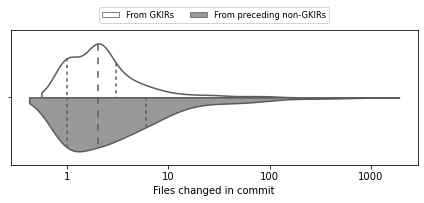

In [77]:
for_plot = number_of_file_changes.copy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
sns.violinplot(
    data=for_plot,
    x='log_files_changed',
    y='placeholder',
    hue='type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
    scale='width',
    bw=0.35
)
ax.set_xlabel('Files changed in commit')
ax.set_ylabel('')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
# ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2
)

L.get_texts()[0].set_text('From GKIRs')
L.get_texts()[1].set_text('From preceding non-GKIRs')

save_fig('number_of_files_changed_per_commit')

plt.show()

In [78]:
mannwhitneyu_cliffsdelta(
    number_of_file_changes[number_of_file_changes['type'] == 'gkir']['files_changed'],
    number_of_file_changes[number_of_file_changes['type'] == 'non-gkir']['files_changed']
)

tfns(
    gkir_number_of_file_changes,
    ['files_changed'],
    title='GKIR number of files changed'
)
tfns(
    ngkir_number_of_file_changes,
    ['files_changed'],
    title='GKIR number of files changed'
)

	Mann-Whitney: statistic=625712.0 pvalue=2.3287771950153063e-07
	Cliff'a Delta: delta=-0.1228615165499414 size=negligible
    
GKIR number of files changed      Count    Mean     STD    Min    25%    Median    75%    Max
------------------------------  -------  ------  ------  -----  -----  --------  -----  -----
files_changed                      2044   4.183  10.066      1      1         2      3    100

GKIR number of files changed      Count    Mean     STD    Min    25%    Median    75%    Max
------------------------------  -------  ------  ------  -----  -----  --------  -----  -----
files_changed                       698  12.319  52.009      1      1         2      6    800



<h3>Size of these commits change?</h3>

In [48]:
gkir_size_of_changes = (
    gkir_referenced_commits
        .groupby('commit_sha')['stats_total']
        .first()
        .to_frame(name='stats_total')
        .reset_index()
)
gkir_size_of_changes['type'] = 'gkir'
ngkir_size_of_changes = (
    ngkir_referenced_commits
        .groupby('commit_sha')['stats_total']
        .first()
        .to_frame(name='stats_total')
        .reset_index()
)
ngkir_size_of_changes = ngkir_size_of_changes[ngkir_size_of_changes['stats_total'] > 0]
ngkir_size_of_changes['type'] = 'non-gkir'
size_of_changes = gkir_size_of_changes.append(ngkir_size_of_changes)

size_of_changes['log_stats_total'] = np.log10(size_of_changes['stats_total'])
size_of_changes['placeholder'] = ''

Saving figure size_of_commits


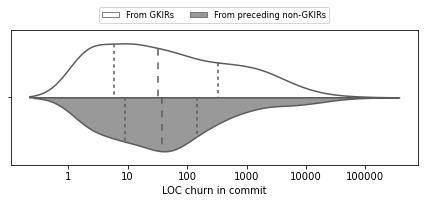

In [79]:
for_plot = size_of_changes.copy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
sns.violinplot(
    data=for_plot,
    x='log_stats_total',
    y='placeholder',
    hue='type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
    scale='width',
    bw=0.3,
)
ax.set_xlabel('LOC churn in commit')
ax.set_ylabel('')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels([1, 10, 100, 1000, 10000, 100000])
# ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2
)

L.get_texts()[0].set_text('From GKIRs')
L.get_texts()[1].set_text('From preceding non-GKIRs')

save_fig('size_of_commits')

plt.show()


In [52]:
mannwhitneyu_cliffsdelta(
    size_of_changes[size_of_changes['type'] == 'gkir']['stats_total'],
    size_of_changes[size_of_changes['type'] == 'non-gkir']['stats_total']
)

tfns(
    gkir_size_of_changes,
    ['stats_total'],
    title='GKIR size of changes'
)
tfns(
    ngkir_size_of_changes,
    ['stats_total'],
    title='Non-GKIR size of changes'
)

	Mann-Whitney: statistic=706956.5 pvalue=0.3826902149091883
	Cliff'a Delta: delta=-0.007549127235257618 size=negligible
    
GKIR size of changes      Count     Mean      STD    Min    25%    Median    75%    Max
----------------------  -------  -------  -------  -----  -----  --------  -----  -----
stats_total                2044  875.707  4046.38      1      6        33    326  81555

Non-GKIR size of changes      Count     Mean      STD    Min    25%    Median    75%    Max
--------------------------  -------  -------  -------  -----  -----  --------  -----  -----
stats_total                     697  926.481  4783.41      1      9        38    146  81555



<h3>Just compare across all issue reports</h3>

In [54]:
gkir_commits_that_change_dep_files_only = commits.groupby('commit_sha').filter(lambda group: commit_only_changes_files(group, DEPS_SPEC_FILES))
gkir_shas_that_change_dep_files_only = gkir_commits_that_change_dep_files_only['commit_sha'].unique()
gkir_commits_that_change_other_files = commits[~commits['commit_sha'].isin(gkir_shas_that_change_dep_files_only)]

ngkir_commits_that_change_dep_files_only = ngkir_commits.groupby('commit_sha').filter(lambda group: commit_only_changes_files(group, DEPS_SPEC_FILES))
ngkir_shas_that_change_dep_files_only = ngkir_commits_that_change_dep_files_only['commit_sha'].unique()
ngkir_commits_that_change_other_files = ngkir_commits[~ngkir_commits['commit_sha'].isin(ngkir_shas_that_change_dep_files_only)]

In [55]:
gkir_prop = calculate_percent(
    gkir_commits_that_change_dep_files_only['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_dep_files_only['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f"To recap:")
print(f"{gkir_prop}% of commits referenced from GKIRs only change dependency specification files")
print(f"{ngkir_prop}% of commits referenced from non-GKIRs only change dependency specification files")

To recap:
55.87% of commits referenced from GKIRs only change dependency specification files
3.63% of commits referenced from non-GKIRs only change dependency specification files


In [56]:
gkir_commits_that_change_package_json = commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, ['package.json']))
gkir_prop = calculate_percent(
    gkir_commits_that_change_package_json['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)

ngkir_commits_that_change_package_json = ngkir_commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, ['package.json']))
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_package_json['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f'{gkir_prop}% of commits referenced from GKIRs change package.json file')
print(f'{ngkir_prop}% of commits referenced from non-GKIRs change package.json file')


77.74% of commits referenced from GKIRs change package.json file
17.44% of commits referenced from non-GKIRs change package.json file


In [57]:
gkir_commits_that_change_package_lock_json = commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, ['package-lock.json']))
gkir_prop = calculate_percent(
    gkir_commits_that_change_package_lock_json['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)

ngkir_commits_that_change_package_lock_json = ngkir_commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, ['package-lock.json']))
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_package_lock_json['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f'{gkir_prop}% of commits referenced from GKIRs change package-lock.json file')
print(f'{ngkir_prop}% of commits referenced from non-GKIRs change package-lock.json file')

28.28% of commits referenced from GKIRs change package-lock.json file
3.81% of commits referenced from non-GKIRs change package-lock.json file


In [58]:
gkir_commits_that_change_yarn_lock = commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, ['yarn.lock']))
gkir_prop = calculate_percent(
    gkir_commits_that_change_yarn_lock['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)

ngkir_commits_that_change_yarn_lock = ngkir_commits.groupby('commit_sha').filter(lambda group: commit_changes_file(group, ['yarn.lock']))
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_yarn_lock['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f'{gkir_prop}% of commits referenced from GKIRs change yarn.lock file')
print(f'{ngkir_prop}% of commits referenced from non-GKIRs change yarn.lock file')

26.96% of commits referenced from GKIRs change yarn.lock file
2.94% of commits referenced from non-GKIRs change yarn.lock file


In [65]:
gkir_commits_that_change_dep_files_only__packagejson = (
    gkir_commits_that_change_dep_files_only[
        gkir_commits_that_change_dep_files_only['file_name'] == 'package.json'
    ].groupby('commit_sha')
    .first()
    .reset_index()
)

grouped_by_file_changes = \
    gkir_commits_that_change_dep_files_only__packagejson.groupby(['file_changes', 'file_additions', 'file_deletions'])['commit_sha']

grouped_by_file_changes.count()

for_plot = (
    (
        grouped_by_file_changes.count() /
        grouped_by_file_changes.count().sum()
    ).sort_values(ascending=False)
    .reset_index(name='proportion')
)
for_plot['label'] = for_plot.apply(
    lambda row: f"{int(row['file_changes'])} ({int(row['file_additions'])}, {int(row['file_deletions'])})",
    axis=1
)
for_plot

,file_changes,file_additions,file_deletions,proportion,label
0,2,1,1,0.549189,"2 (1, 1)"
1,4,2,2,0.110270,"4 (2, 2)"
2,6,3,3,0.050811,"6 (3, 3)"
3,10,5,5,0.032432,"10 (5, 5)"
4,12,6,6,0.025946,"12 (6, 6)"
...,...,...,...,...,...
61,14,8,6,0.001081,"14 (8, 6)"
62,14,9,5,0.001081,"14 (9, 5)"
63,18,1,17,0.001081,"18 (1, 17)"
64,18,11,7,0.001081,"18 (11, 7)"


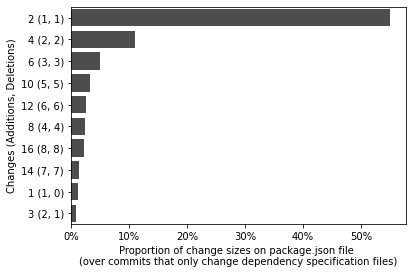

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
sns.barplot(
    data=for_plot.head(10),
    y='label',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of change sizes on package.json file \n(over commits that only change dependency specification files)')
ax.set_ylabel('Changes (Additions, Deletions)')
ax.xaxis.set_major_formatter(proportion_func_formatter)
plt.show()

In [70]:
single_line_change_labels = [
    '1 (1, 0)',
    '1 (0, 1)',
    '2 (1, 1)'
]

prop_that_modify_one_line = (
    for_plot[
        for_plot['label'].isin(single_line_change_labels)
    ]['proportion'].sum()
)

less_than_three_labels = [
    '1 (1, 0)',
    '1 (0, 1)',
    '2 (1, 1)',
    '2 (2, 0)',
    '2 (0, 2)',
    '3 (3, 0)',
    '3 (2, 1)',
    '3 (1, 2)',
    '3 (0, 3)',
    '4 (3, 1)',
    '4 (2, 2)',
    '4 (1, 3)',
    '6 (3, 3)',
]
prop_that_modify_three_lines = (
    for_plot[
        for_plot['label'].isin(less_than_three_labels)
    ]['proportion'].sum()
)
print("GKIR referenced commits that only change deps files (package.json file changes)")

print(f"{prop_that_modify_one_line}% are one-line changes")
print(f"{prop_that_modify_three_lines}% modify three or fewer lines")

GKIR referenced commits that only change deps files (package.json file changes)
0.5675675675675677% are one-line changes
0.7513513513513514% modify three or fewer lines


In [71]:
ngkir_commits_that_change_dep_files_only__packagejson = (
    ngkir_commits_that_change_dep_files_only[
        ngkir_commits_that_change_dep_files_only['file_name'] == 'package.json'
    ].groupby('commit_sha')
    .first()
    .reset_index()
)

grouped_by_file_changes = (
    ngkir_commits_that_change_dep_files_only__packagejson
        .groupby(['file_changes', 'file_additions', 'file_deletions'])
        ['commit_sha']
)

for_plot = (
    (
        grouped_by_file_changes.count() /
        grouped_by_file_changes.count().sum()
    ).sort_values(ascending=False)
    .reset_index(name='proportion')
)
for_plot['label'] = for_plot.apply(
    lambda row: f"{int(row['file_changes'])} ({int(row['file_additions'])}, {int(row['file_deletions'])})",
    axis=1
)
for_plot

,file_changes,file_additions,file_deletions,proportion,label
0,2,1,1,0.654391,"2 (1, 1)"
1,4,2,2,0.057467,"4 (2, 2)"
2,1,1,0,0.048563,"1 (1, 0)"
3,3,2,1,0.025900,"3 (2, 1)"
4,6,3,3,0.024282,"6 (3, 3)"
...,...,...,...,...,...
117,22,11,11,0.000405,"22 (11, 11)"
118,22,18,4,0.000405,"22 (18, 4)"
119,23,22,1,0.000405,"23 (22, 1)"
120,24,13,11,0.000405,"24 (13, 11)"


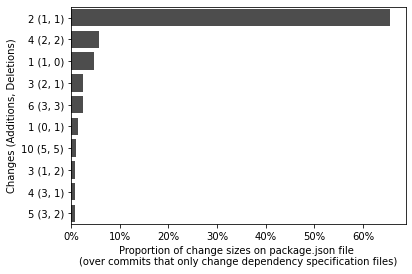

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
sns.barplot(
    data=for_plot.head(10),
    y='label',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of change sizes on package.json file \n(over commits that only change dependency specification files)')
ax.set_ylabel('Changes (Additions, Deletions)')
ax.xaxis.set_major_formatter(proportion_func_formatter)
# save_fig('')
plt.show()

In [74]:
single_line_change_labels = [
    '1 (1, 0)',
    '1 (0, 1)',
    '2 (1, 1)'
]
prop_that_modify_one_line = (
    for_plot[
        for_plot['label'].isin(single_line_change_labels)
    ]['proportion'].sum()
)
less_than_three_labels = [
    '1 (1, 0)',
    '1 (0, 1)',
    '2 (1, 1)',
    '2 (2, 0)',
    '2 (0, 2)',
    '3 (3, 0)',
    '3 (2, 1)',
    '3 (1, 2)',
    '3 (0, 3)',
    '4 (3, 1)',
    '4 (2, 2)',
    '4 (1, 3)',
    '6 (3, 3)',
]
prop_that_modify_three_lines = (
    for_plot[
        for_plot['label'].isin(less_than_three_labels)
    ]['proportion'].sum()
)

print("Non-GKIR referenced commits that only change deps files (package.json file changes)")
print(f"{prop_that_modify_one_line}% are one-line changes")

print(f"{prop_that_modify_three_lines}% modify three or fewer lines")

Non-GKIR referenced commits that only change deps files (package.json file changes)
0.7183326588425739% are one-line changes
0.8624038850667747% modify three or fewer lines
